- This implementation follow this [Post](https://towardsdatascience.com/graph-convolutional-networks-on-node-classification-2b6bbec1d042)
- [Github](https://github.com/imayachita/Graph_Convolutional_Networks_Node_Classification)

- This article goes through the implementation of Graph Convolution Networks (GCN) using **Spektral API**, which is a Python library for graph deep learning based on Tensorflow 2.

**[Cora](https://graphsandnetworks.com/the-cora-dataset/)** - The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

**Dataset Overview**<br>
CORA citation network dataset consists of 2708 nodes, where each node represents a document or a technical paper. The **node features** are bag-of-words representation that indicates the presence of a word in the document. The vocabulary — hence, also the node features — contains 1433 words.

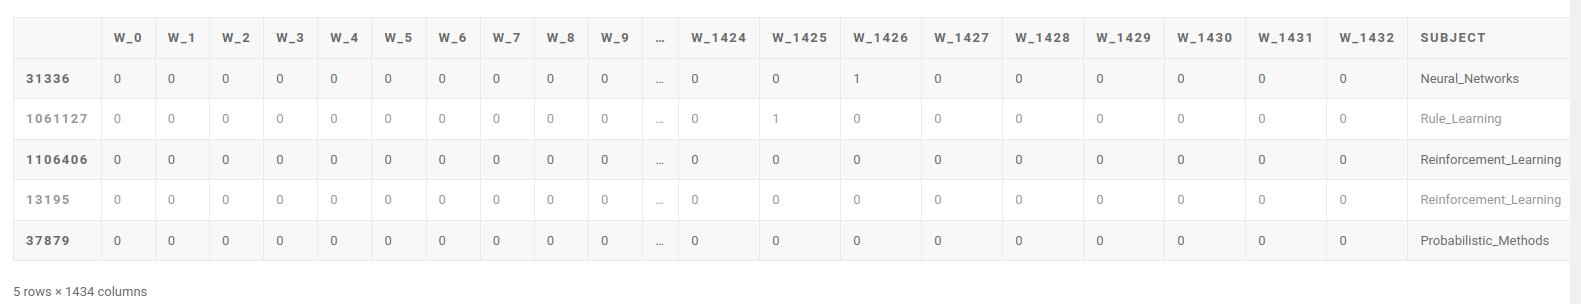


The goal of this task is to classify the nodes (or the documents) into **7 different classes** which correspond to the papers’ research areas
```
{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}
```



In [1]:
!pip install python-dateutil==2.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -r '/content/gcn.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###### Load the Dataset

In [3]:
import numpy as np
import os
import networkx as nx
import tensorflow as tf

In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import spektral
from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(os.listdir('/content/drive/MyDrive/cora'))

['cora.content', 'cora.edges', 'cora.node_labels', 'cora.cites', '.ipynb_checkpoints', 'Tensor_GCN_Cora']


In [7]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('/content/drive/MyDrive/cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
#Shuffle the data because the raw data is ordered based on the label
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

- In cora.content file, each line consists of several elements:
the first element indicates the document (or node) ID,
the second until the last second elements indicate the node features,
the last element indicates the label of that particular node.

- In cora.cites file, each line contains a tuple of documents (or nodes) IDs. The first element of the tuple indicates the ID of the paper being cited, while the second element indicates the paper containing the citation. Although this configuration represents a directed graph, in this approach we treat the dataset as an undirected graph.

In [10]:
# Parse the Data
labels = []
nodes = []
X = []

for i, data in enumerate(all_data):
  elements = data.split('\t')
  labels.append(elements[-1]) # Get the last row of the dataset
  X.append(elements[1:-1]) # get from Row 1 to  before the last row
  nodes.append(elements[0]) # get the Row 0

X = np.array(X, dtype=int)
N = X.shape[0] # The number of Nodes ... In
F = X.shape[1] # The size of the node features ... In this case, it is 1433
print('X shape: ', X.shape)

# Parse the edge
edge_list = []
for edge in all_edges:
  e = edge.split('\t')
  edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Reinforcement_Learning', 'Genetic_Algorithms', 'Case_Based', 'Rule_Learning', 'Probabilistic_Methods', 'Theory', 'Neural_Networks'}

Number of classes:  7


**Setting the Train, Validation, and Test Mask**<br>
We will feed in the Node Features Matrix (X) and Adjacency Matrix (A) to the neural networks. We are also going to set Boolean masks with a length of N for each training, validation, and testing dataset. The elements of those masks are True when they belong to corresponding training, validation, or test dataset. For example, the elements of train mask are True for those which belong to training data.

<img src ="https://miro.medium.com/max/4800/1*nuanGfgWcumBM-jb6cOtiA.png">


- In the paper, they pick 20 labeled examples for each class. Hence, with 7 classes, we will have a total of 140 labeled training examples. We will also use 500 labeled validation examples and 1000 labeled testing examples.

In [11]:
def limit_data(labels, limit = 20, val_num = 500, test_num = 1000):
  """
  Get the index of train, validation, test_data
  """
  label_counter = dict((l, 0) for l in labels)
  train_idx = []

  for i in range(len(labels)):
    label = labels[i]
    if label_counter[label]<limit:
      train_idx.append(i)
      label_counter[label]+=1

    #Exit the loop once we found the 20 examples for each class
    if all(count == limit for count in label_counter.values()):
      break
    
    # Get the indices that do not go to training data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = limit_data(labels)

# Set the Mask

train_mask = np.zeros((N,),dtype = bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [12]:
# Get the Adjacency matrix
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [13]:
# Converting the label to one-hot encoding

def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

- The GCN model will take 2 inputs, the Node Features Matrix (X) and Adjacency Matrix (A). We are going to implement **2-layer GCN** with Dropout layers and **L2 regularization**. We are also going to set the maximum training epochs to be 200 and implement Early Stopping with patience of 10. It means that the training will be stopped once the validation loss does not decrease for 10 consecutive epochs. To monitor the training and validation accuracy and loss, we are also going to call TensorBoard in the callbacks.

**Normalization**

<img src ="https://miro.medium.com/max/640/1*DKWEsqvmm74KwLS-eM1G8w.png">

---
---
**Renormalization trick**

<img src ="https://miro.medium.com/max/640/1*yd8uL8Ewj_C4ES5faZVUxg.png">

#### Building and Training Graph Convolutional Networks

In [14]:
"""
The Code was take from offical Spektral Github: 
https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py
"""
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GraphConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
print(X_in.shape)
fltr_in = Input((N, ), sparse=True)
print(fltr_in.shape)
dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

(None, 1433)
(None, 2708)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1433)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 16)           22928       dropout[0][0]                    
                                                                 inp

- We are implementing Transductive Learning, which means we will feed the whole graph to both training and testing. We separate the training, validation, and testing data using the Boolean masks we have constructed before. These masks will be passed to sample_weight argument

In [15]:
# Train model
validation_data = ([X, A], labels_encoded, val_mask)

model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 0s 439ms/step - loss: 0.0166 - acc: 0.0000e+00 - val_loss: 0.3674 - val_acc: 0.1780
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.0106 - acc: 1.0000

1/1 [==============================] - 0s 233ms/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.3630 - val_acc: 0.1740
Epoch 3/200
1/1 [==============================] - 0s 223ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.1280
Epoch 4/200
1/1 [==============================] - 0s 219ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.3589 - val_acc: 0.1020
Epoch 5/200
1/1 [==============================] - 0s 233ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3585 - val_acc: 0.0980
Epoch 6/200
1/1 [==============================] - 0s 212ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.3588 - val_acc: 0.0960
Epoch 7/200
1/1 [==============================] - 0s 225ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3596 - val_acc: 0.0940
Epoch 8/200
1/1 [==============================] - 0s 217ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.3604 - val_acc: 0.0940
Epoch 9/200
1/1 [==============================] - 0s 227ms/step - loss: 0.0018 - acc: 1.0000 -

In [16]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.00      0.00      0.00       116
    Genetic_Algorithms       0.00      0.00      0.00       167
       Neural_Networks       0.52      0.04      0.08       279
 Probabilistic_Methods       0.00      0.00      0.00       176
Reinforcement_Learning       0.09      0.99      0.16        84
         Rule_Learning       0.00      0.00      0.00        56
                Theory       0.00      0.00      0.00       122

              accuracy                           0.10      1000
             macro avg       0.09      0.15      0.03      1000
          weighted avg       0.15      0.10      0.04      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Get hidden layer representation for GCN


In [17]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

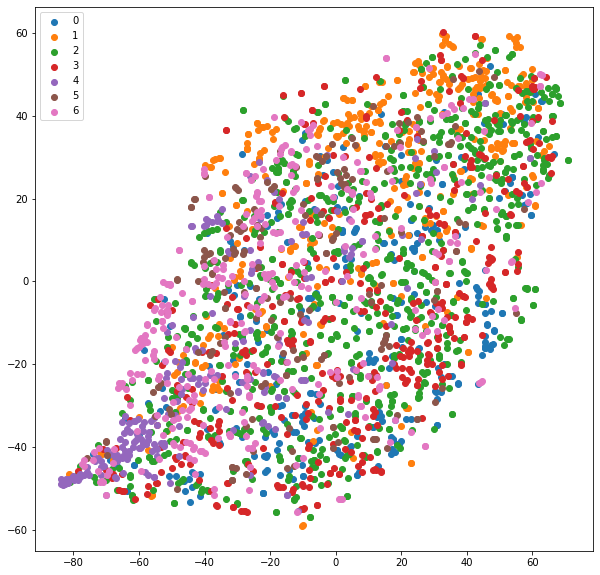

In [18]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

#### Comparison to Fully-Connected Neural Networks
#### Building and Training FNN

In [34]:
es_patience = 10
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 0s 289ms/step - loss: 0.1187 - acc: 0.0000e+00 - val_loss: 0.4352 - val_acc: 0.1240
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.0733 - acc: 1.0000

1/1 [==============================] - 0s 215ms/step - loss: 0.0733 - acc: 1.0000 - val_loss: 0.4030 - val_acc: 0.0960
Epoch 3/200
1/1 [==============================] - 0s 204ms/step - loss: 0.0410 - acc: 1.0000 - val_loss: 0.3837 - val_acc: 0.0940
Epoch 4/200
1/1 [==============================] - 0s 194ms/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.3757 - val_acc: 0.0940
Epoch 5/200
1/1 [==============================] - 0s 206ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.3777 - val_acc: 0.0940
Epoch 6/200
1/1 [==============================] - 0s 207ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.3879 - val_acc: 0.0940
Epoch 7/200
1/1 [==============================] - 0s 212ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.4040 - val_acc: 0.0940
Epoch 8/200
1/1 [==============================] - 0s 198ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.4236 - val_acc: 0.0940
Epoch 9/200
1/1 [==============================] - 0s 202ms/step - loss: 0.0120 - acc: 1.0000 -

In [35]:
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

FCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.00      0.00      0.00       116
    Genetic_Algorithms       0.00      0.00      0.00       167
       Neural_Networks       0.00      0.00      0.00       279
 Probabilistic_Methods       0.00      0.00      0.00       176
Reinforcement_Learning       0.08      1.00      0.15        84
         Rule_Learning       0.00      0.00      0.00        56
                Theory       0.00      0.00      0.00       122

              accuracy                           0.08      1000
             macro avg       0.01      0.14      0.02      1000
          weighted avg       0.01      0.08      0.01      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

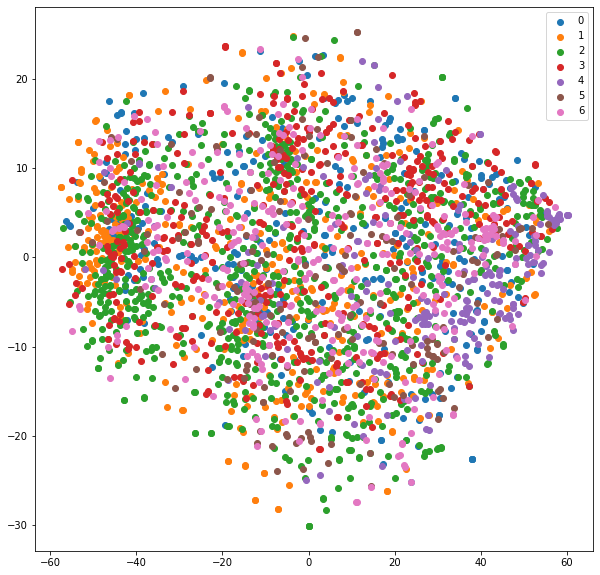

In [37]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)